In [1]:
import pynq
import time
from pynq import PL
import xrfclk
import xrfdc
import numpy as np
from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import scipy.io as sio
import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.daccomb as daccomb
import mkidgen3
import mkidgen3.util
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc
from mkidgen3.ifboard import IFBoard
import logging
from logging import getLogger
import json

In [2]:
#logging.basicConfig()
#logging.getLogger('mkidgen3').setLevel('INFO')

In [3]:
ol = g3.configure('../iqtest/se_v2/iqtest.bit', clocks=True, external_10mhz=True, ignore_version=True)
print(f"PL Bitfile: {PL.bitfile_name}\nPL Timestamp: {PL.timestamp}\n"
      f"Overlay timestamp: {ol.timestamp}  Loaded: {ol.is_loaded()}")

PL Bitfile: /home/xilinx/jupyter_notebooks/iqtest/se_v2/iqtest.bit
PL Timestamp: 2022/3/4 23:0:39 +3054
Overlay timestamp: 2022/3/4 23:0:39 +3054  Loaded: True


In [60]:
ol?

## Setup DAC REPLAY

In [58]:
tones = np.array([0.1e9])
amplitudes = np.array([1])

In [59]:
dactable = g3.set_waveform(tones, amplitudes, fpgen=lambda x: (x*2**15).astype(np.uint16))
qtones = dactable['frequencies']
qphases = dactable['phases']
iqtable = dactable['iq']

In [44]:
ol.dac_table_axim_0.stop()

In [46]:
ol.dac_table_axim_0.replay(np.zeros(2**19))

## ADC Capture

In [47]:
adc_cap_result=ol.capture.capture_adc(2**19)
adc_capture_data = adc_cap_result[:,0] + 1j*adc_cap_result[:,1]
adc_capture_data/=2**15
del adc_cap_result

## Plot ADC Out

In [48]:
N = 2**19
Fs = 4.096e9 # ADC Sample Rate [Hz]
Tc = N/Fs # total collection time (seconds)
time = np.linspace(0,Tc,N) # Time vector (seconds)

In [49]:
ol.capture.axis2mm.len,ol.capture.stream_limit_0.register_map

(2097152,
 RegisterMap {
   n = Register(n=0, RESERVED=0)
 })

In [50]:
np.log2(2097152/4)

19.0

### Time Series

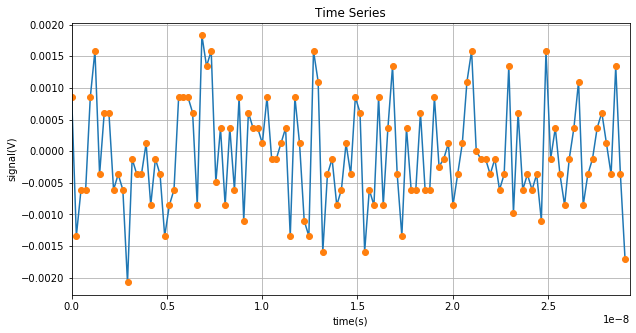

In [51]:
timeseries_plot_start=0
timeseries_plot_stop= 120#20*4096+16
timeseries_sl = slice(timeseries_plot_start,timeseries_plot_stop)

plt.figure(figsize=(10,5))
# plt.plot(time[sl],(ps_buf&0xffff)[sl].astype(np.int16), '-', label='real')
plt.plot(time[timeseries_sl],adc_capture_data.real[timeseries_sl])
plt.plot(time[timeseries_sl],adc_capture_data.real[timeseries_sl],"o")
plt.grid(True)
plt.xlabel("time(s)",position=(0.5,1))
plt.ylabel("signal(V)",position=(0,0.5))
ax = plt.gca()
ax.set_xlim(time[timeseries_plot_start],time[timeseries_plot_stop])
#plt.legend()
plt.title('Time Series')
plt.show()

### FFT

In [52]:
fft_start = 16
fft_stop = 20*4096+16
fft_sl = slice(fft_start, fft_stop)
fft_freqs = np.linspace(-2.048e9,2.048e9,fft_stop-fft_start)
y_fft = 20*np.log10(np.abs(fftshift(fft(adc_capture_data[fft_sl]))))         # Calculate the FFT, and also shift so that f=0Hz is in the center.

In [53]:
def plot_fft(f, y, log=False, xlim=(-2.048e9,2.048e9), ylim=None):
    plt.plot(fft_freqs[::2],y_fft[::2] - max(y_fft)) # Plot every other
    plt.grid(True)
    ax = plt.gca()
    if log:
        plt.yscale("log")
    if ylim is not None:
        plt.ylim(*ylim)
    if xlim is not None:
        plt.xlim(*xlim)
    plt.xlabel("Frequency[Hz]", position=(0.5,0.5))
    plt.ylabel("power", position=(1,0.5))
    plt.title('FFT')

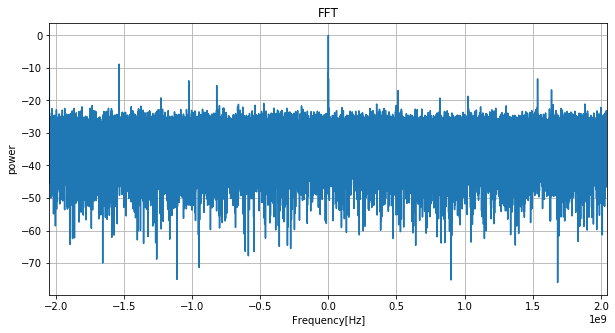

In [54]:
plt.figure(figsize=(10,5))
#plt.subplot(211)
plot_fft(fft_freqs[::2], y_fft[::2] - max(y_fft))
#plt.subplot(212)
#plot_fft(fft_freqs[::2], y_fft[::2] - max(y_fft), xlim=(75e6,125e6))
#plt.tight_layout()

## Resonator selection

In [ ]:
g3.set_channels(tones)
ol.photon_pipe.reschan.bin_to_res.bins

#### Or manually

In [ ]:
bins = np.zeros(2048, dtype=int)
bins[:tones.size] = g3.drivers.bintores.opfb_bin_number(tones)+2048
ol.photon_pipe.reschan.bin_to_res.bins=bins

## DDC Configuration

In [ ]:
g3.set_tones(tones)
ol.photon_pipe.reschan.resonator_ddc.tones

#### Or manually

In [ ]:
ddctones = np.zeros((2, 2048))
ddctones[0, :tones.size] = g3.drivers.ddc.tone_increments(tones)
ddctones[1, :tones.size] = 0  #Phase offsets to 0
ol.photon_pipe.reschan.resonator_ddc.tones = ddctones

In [ ]:
b=ol.capture.capture_iq(256, groups='all', tap_location='rawiq', prepare=False)
x=b.copy()
del b
fig,axes=plt.subplots(2,5,figsize=(12,8))
for i,ax in zip(range(10),axes.flat):
    plt.sca(ax)
    plt.plot(x[:50,i]/2**15)
    plt.title(f'Chan {i} Bin {bins[i]}')
    plt.ylim(-1,1)
plt.figure()
b=ol.capture.capture_iq(256, groups='all', tap_location='rawiq', prepare=False)
x=b.copy()
del b
fig,axes=plt.subplots(2,5,figsize=(12,8))
for i,ax in zip(range(10),axes.flat):
    plt.sca(ax)
    plt.plot(x[:50,i]/2**15)
    plt.title(f'Chan {i} Bin {bins[i]}')
    plt.ylim(-1,1)

## OPFB Capture

In [12]:
def capture_opfb(n=256):
    out = np.zeros((n, 4096), dtype=np.complex64)
    ol.photon_pipe.reschan.bin_to_res.bins=range(0, 4096,2)
    x = ol.capture.capture_iq(n, 'all',tap_location='rawiq', prepare=False)
    out[:,::2].real = x[...,0]/2**15
    out[:,::2].imag = x[...,1]/2**15
    x.freebuffer()
    
    ol.photon_pipe.reschan.bin_to_res.bins=range(1, 4096,2)
    y = ol.capture.capture_iq(n, 'all',tap_location='rawiq', prepare=False)
    out[:, 1::2].real = y[...,0]/2**15
    out[:, 1::2].imag = y[...,1]/2**15
    y.freebuffer()
    return out

In [55]:
opfb_out = capture_opfb(1024)

In [ ]:
opfb_bin_fft = np.fft.fft(opfb_out,axis=0)

In [ ]:
d=np.fft.fftshift(20*np.log10(np.abs(opfb_bin_fft)))
plt.imshow(d[:,b-128:b+128])

In [ ]:
for b in [2046,2149]:
    plt.subplot
    plt.plot(np.fft.fftshift(20*np.log10(np.abs(opfb_bin_fft[:,b])))[1:])

In [ ]:
opfb_out.shape

In [ ]:
sio.savemat('100MHz_OPFB_out_test2.mat', mdict={'opfb_out_test_2':opfb_out})

In [ ]:
def gen_bin_cen(bin):
    return bin-2047

In [ ]:
gen_bin_cen(4095)

In [ ]:
bin_center = -2047

plt.plot(np.linspace(-2047-1,-2047+1,a_fft.shape[0]), np.fft.fftshift(20*np.log10(np.abs(a_fft[:,3000]))))
plt.plot(np.linspace(-2046-1,-2046+1,a_fft.shape[0]), np.fft.fftshift(20*np.log10(np.abs(a_fft[:,3001]))))


def plot_opfb_bins(data_in, bins, overlap=True):
    def gen_bin_freqs:
        return linspace()

In [ ]:
opfb_cap_result = ol.capture.capture_iq(8192, groups='all', tap_location='iq', duration=False) #rawiq=bin2res #iq=lowpassed  #ddciq=before lowpass (unsupported)

In [ ]:
opfb_cap_result.shape

In [ ]:
opfb_capture_data = opfb_cap_result[:,:,0]/2**15 + 1j*opfb_cap_result[:,:,1]/2**15

In [ ]:
opfb_cap_result.freebuffer()

In [ ]:
opfb_capture_data.shape

### Scratchpad

In [ ]:
# Load golden matlab data
mat_contents = sio.loadmat('100_MHz_Golden.mat')
data_out = mat_contents['matlab_sim_out'][0:1024,:]

In [ ]:
data_out.shape

In [ ]:
shifted_data = np.fft.fftshift(data_out, axes=1)

In [18]:
def opfb_bin_spectrum(data, bin, fine_fft_shift = True, left_snip=1): 
    """
    Inputs:
    - bin: OPFB bin number (allowed values 0 - 4095)
    - data: Raw data out of OPFB. Should be in the form N x 4096 where N is the number of samples from a single bin.
    - fine_fft_shift: boolean. Either apply to every OPFB bin or don't (this should always be applied).
    - left_snip: Cuts out the left most sample in a bin. This is an annoying crutch to handle the 
        fact we place the N/2 bin on the far left.
        See https://www.gaussianwaves.com/2015/11/interpreting-fft-results-complex-dft-frequency-bins-and-fftshift/
        for explanation.
        
    Output:
    - Returns spectrum of a single FFT bin.
    """
    if fine_fft_shift:
        return(20*np.log10(np.fft.fftshift(np.abs(np.fft.fft(data[:,bin]))))[left_snip:,])
    else:
        return(20*np.log10(np.abs(np.fft.fft(data[:,bin]))))[left_snip:,]

In [19]:
def opfb_bin_freq(bin, resolution, Fs=4.096e9, M=4096, OS=2, left_snip=1):
    """
    Inputs:
    - bin: OPFB bin (0-4095). bin 0 contains -2048 to -2046 MHz, bin 4095 contains 2045 to 2047 MHz.
    - resolution: the number of samples from a single bin to take the FFT of. This dictates the frequency 
        resolution in a single OPFB bin.
    - Fs: ADC Sampling Rate.
    - M: OPFB FFT Size.
    - OS: Oversample ratio.
    - left_snip: Cuts out the left most sample in a bin. This is an annoying crutch to handle the 
        fact we place the N/2 bin on the far left.
        See https://www.gaussianwaves.com/2015/11/interpreting-fft-results-complex-dft-frequency-bins-and-fftshift/
        for explanation.
        
    Outputs:
    - Returns an array of frequency values in Hz for the given OPFB bin. """
    bin_centers = (Fs/M)*np.linspace(-M/2,M/2-1,M)
    bin_width = (Fs/M)*OS
    base_freq = np.linspace(-bin_width/2,bin_width/2-1,resolution-left_snip)
    return(base_freq+bin_centers[bin])

In [20]:
def plot_opfb_bins(data, bins, fine_fft_shift = True, fft_shift = True, left_snip=1, ol=True):
    """
    Inputs:
    - data: Raw data out of OPFB. Should be in the form N x 4096 where N is the number of samples from a single bin.
    - bins: list of OPFB bins 0 to 4095 (note bin 0 is far left in the +/- 2 GHz spectrum).
    - fine_fft_shift: boolean. To apply an fft shift to the fine fft spectrum of each bin or not. (You should.)
    - fft_shift: boolean. To apply an fft shift to the entire OPFB output spectrum or not. (You should.)
    - ol: To plot the bins as overlapping or discard the overlap region."""
    
    if fft_shift:
        data = np.fft.fftshift(data, axes=1)
    for b in bins:
        plt.plot(opfb_bin_freq(b,data.shape[0]), opfb_bin_spectrum(data,b))

In [ ]:
plot_opfb_bins(shifted_data,[73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91])

In [ ]:
for bin in all_bins:
    plt.plot(np.max())

In [31]:
opfb_out.shape

(1024, 4096)

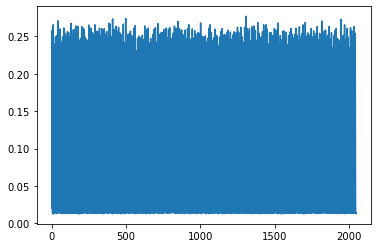

In [57]:
plt.plot(np.abs(opfb_out).mean(axis=0)[1::2])

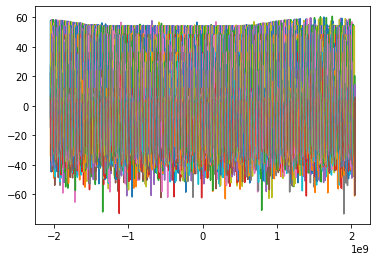

In [24]:
plot_opfb_bins(opfb_out,all_bins)

In [ ]:
a = np.array([[1,2],[4,5],[7,8]])

In [ ]:
np.fft.fftshift(a, axes=0)

In [23]:
all_bins = np.linspace(0,4095,4096).astype(int)
all_bins = np.ndarray.tolist(all_bins)

In [ ]:
x = np.linspace(2048+70,2048+101,50).astype(int)
x = np.ndarray.tolist(x)

In [ ]:
x